# 03 feature engineering - TODO

## Purpose
To be filled during project development

## Steps
1. 
2. 
3. 

In [1]:
# CELL 1: Setup with correct paths
import os
import sys

# Get project root (one level up from notebooks)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Define common paths
DATA_RAW = os.path.join(project_root, 'data', 'raw')
DATA_PROCESSED = os.path.join(project_root, 'data', 'processed')
FIGURES = os.path.join(project_root, 'figures')
MODELS = os.path.join(project_root, 'models')

# Create directories
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_PROCESSED, exist_ok=True)
os.makedirs(FIGURES, exist_ok=True)
os.makedirs(MODELS, exist_ok=True)

print(f"📁 Project root: {project_root}")
print(f"📁 Data raw: {DATA_RAW}")
print(f"📁 Data processed: {DATA_PROCESSED}")

# Now import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import joblib
import pickle
import json


print("\n🔧 Feature Engineering for EUR/USD LSTM Prediction")
print("="*50)

📁 Project root: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone
📁 Data raw: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/raw
📁 Data processed: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed

🔧 Feature Engineering for EUR/USD LSTM Prediction


In [2]:
# CELL 2: Load processed data (from notebook 2)
processed_file = os.path.join(DATA_PROCESSED, 'eurusd_processed.csv')

if not os.path.exists(processed_file):
    print(f"❌ ERROR: File not found: {processed_file}")
    print("Please run 02_eda.ipynb first!")
    df = None
else:
    df = pd.read_csv(processed_file, index_col=0, parse_dates=True)
    print(f"✅ Loaded {len(df)} rows with {len(df.columns)} columns")
    print(f"📅 Date range: {df.index[0].date()} to {df.index[-1].date()}")

✅ Loaded 778 rows with 9 columns
📅 Date range: 2022-12-13 to 2025-12-09


In [3]:
# CELL 3: Prepare data for LSTM (Time Series specific)
print("\n🕰️ STEP 1: Prepare time series data for LSTM")

# For LSTM, we mainly need the closing price sequence
# if df is not None:

# Use closing price as our main series
close_prices = df['close'].values.reshape(-1, 1)
print(f"Closing price shape: {close_prices.shape}")

# Normalize data for LSTM (0 to 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_prices)

# Save scaler for later use
scaler_path = os.path.join(MODELS, 'lstm_scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")



🕰️ STEP 1: Prepare time series data for LSTM
Closing price shape: (778, 1)
✅ Scaler saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/models/lstm_scaler.joblib


In [4]:
# CELL 4: Create sequences for LSTM
print("\n📊 STEP 2: Create sequences for LSTM training")

def create_sequences(data, seq_length):
  """Create input sequences and corresponding targets for LSTM"""
  X, y = [], []
  for i in range(len(data) - seq_length):
      X.append(data[i:(i + seq_length)])
      y.append(data[i + seq_length])
  return np.array(X), np.array(y)

# Use 60 days of history to predict next day
SEQ_LENGTH = 60
X, y = create_sequences(scaled_close, SEQ_LENGTH)

print(f"Created {len(X)} sequences")
print(f"X shape: {X.shape} (samples, timesteps, features)")
print(f"y shape: {y.shape}")



📊 STEP 2: Create sequences for LSTM training
Created 718 sequences
X shape: (718, 60, 1) (samples, timesteps, features)
y shape: (718, 1)


In [5]:
# CELL 5: Train-test split for time series
print("\n🎯 STEP 3: Time series train-test split")

# Use 80% for training, 20% for testing (chronological)
split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Training set: {len(X_train)} sequences")
print(f"Testing set:  {len(X_test)} sequences")
print(f"Train dates: {df.index[SEQ_LENGTH].date()} to {df.index[split_idx + SEQ_LENGTH - 1].date()}")
print(f"Test dates:  {df.index[split_idx + SEQ_LENGTH].date()} to {df.index[-1].date()}")


🎯 STEP 3: Time series train-test split
Training set: 574 sequences
Testing set:  144 sequences
Train dates: 2023-03-07 to 2025-05-21
Test dates:  2025-05-22 to 2025-12-09


In [6]:
# CELL 6: Save sequences for LSTM training
print("\n💾 STEP 4: Save LSTM-ready data")

# Save sequences
lstm_data = {
  'X_train': X_train,
  'X_test': X_test,
  'y_train': y_train,
  'y_test': y_test,
  'scaler': scaler,
  'seq_length': SEQ_LENGTH,
  'original_prices': close_prices,
  'dates': df.index[SEQ_LENGTH:].values  # Align with sequences
}

lstm_data_path = os.path.join(DATA_PROCESSED, 'lstm_sequences.pkl')
with open(lstm_data_path, 'wb') as f:
  pickle.dump(lstm_data, f)

print(f"✅ LSTM sequences saved to: {lstm_data_path}")


💾 STEP 4: Save LSTM-ready data
✅ LSTM sequences saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/lstm_sequences.pkl


In [12]:
# DEBUG CELL: Check what's in df before feature engineering
print("\n🔍 DEBUG: Checking df before feature engineering")
print(f"df shape: {df.shape}")
print(f"df columns: {list(df.columns)}")
print(f"df head (first 5 rows):")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Check if 'close' column exists and has data
if 'close' in df.columns:
    print(f"\n'close' column statistics:")
    print(f"  Min: {df['close'].min()}")
    print(f"  Max: {df['close'].max()}")
    print(f"  Mean: {df['close'].mean()}")
    print(f"  Non-null count: {df['close'].notnull().sum()}")
else:
    print("❌ ERROR: 'close' column not found in df!")
    print("Available columns:", list(df.columns))
    
    # Try to rename columns if they have different names
    if 'Close' in df.columns:
        print("Found 'Close' column (capitalized). Renaming to 'close'...")
        df.rename(columns={'Close': 'close'}, inplace=True)
    elif 'CLOSE' in df.columns:
        print("Found 'CLOSE' column. Renaming to 'close'...")
        df.rename(columns={'CLOSE': 'close'}, inplace=True)


🔍 DEBUG: Checking df before feature engineering
df shape: (778, 9)
df columns: ['open', 'high', 'low', 'close', 'volume', 'Daily_Return', 'Year', 'month', 'dayofweek']
df head (first 5 rows):
                open      high       low     close  volume  Daily_Return  \
Date                                                                       
2022-12-13  1.054174  1.066894  1.052931  1.054174       0      0.185529   
2022-12-14  1.062665  1.066985  1.062011  1.062665       0      0.805502   
2022-12-15  1.067635  1.072559  1.060738  1.067635       0      0.467632   
2022-12-16  1.064056  1.066325  1.059940  1.064056       0     -0.335184   
2022-12-19  1.058504  1.065900  1.057720  1.058504       0     -0.521838   

            Year  month  dayofweek  
Date                                
2022-12-13  2022     12          1  
2022-12-14  2022     12          2  
2022-12-15  2022     12          3  
2022-12-16  2022     12          4  
2022-12-19  2022     12          0  

Data types:
op

In [13]:
# CELL 7: Prepare data for traditional ML models (NO VOLUME)
print("\n📈 STEP 5: Create features for traditional ML models (No Volume)")

# Create features that work with Random Forest/Linear Regression
df_ml = df.copy()

print(f"Original df shape before feature engineering: {df_ml.shape}")
print(f"Available columns: {list(df_ml.columns)}")

# Check if volume column exists and what values it has
if 'volume' in df_ml.columns:
    print(f"\n🔍 Volume column analysis:")
    print(f"  Unique values: {df_ml['volume'].unique()[:10]}...")
    print(f"  Non-zero count: {(df_ml['volume'] != 0).sum()}")
    print(f"  Zero count: {(df_ml['volume'] == 0).sum()}")
    print(f"  NaN count: {df_ml['volume'].isnull().sum()}")
    
    # Drop volume column since it's not meaningful for forex
    print("  ⚠️ Dropping 'volume' column (always 0 for forex)")
    df_ml = df_ml.drop(columns=['volume'])

# Keep only price columns for feature engineering
price_cols = ['open', 'high', 'low', 'close']
print(f"\nUsing price columns: {price_cols}")

# Use only 'close' for simplicity in this example
print("Creating features based on closing price...")

# Lag features (past prices)
for lag in [1, 2, 3, 5, 7, 10, 14, 20]:
    df_ml[f'lag_{lag}'] = df_ml['close'].shift(lag)
    print(f"  Created lag_{lag}: price {lag} days ago")

# Rolling statistics
print("\nCreating rolling statistics...")
for window in [5, 10, 20, 50]:
    df_ml[f'sma_{window}'] = df_ml['close'].rolling(window).mean()
    df_ml[f'std_{window}'] = df_ml['close'].rolling(window).std()
    print(f"  Created sma_{window} and std_{window}")

# Rolling min/max
df_ml['rolling_min_20'] = df_ml['close'].rolling(20).min()
df_ml['rolling_max_20'] = df_ml['close'].rolling(20).max()
print("  Created rolling_min_20 and rolling_max_20")

# Price changes (returns)
print("\nCreating price change features...")
df_ml['return_1d'] = df_ml['close'].pct_change(1)
df_ml['return_5d'] = df_ml['close'].pct_change(5)
df_ml['return_20d'] = df_ml['close'].pct_change(20)

# Volatility measures
df_ml['volatility_5d'] = df_ml['return_1d'].rolling(5).std()
df_ml['volatility_20d'] = df_ml['return_1d'].rolling(20).std()

# Technical indicators (simplified)
print("\nCreating technical indicators...")
# RSI-like feature (simplified)
price_diff = df_ml['close'].diff()
gain = price_diff.where(price_diff > 0, 0).rolling(14).mean()
loss = -price_diff.where(price_diff < 0, 0).rolling(14).mean()
rs = gain / loss
df_ml['rsi_simple'] = 100 - (100 / (1 + rs))

# MACD-like feature (simplified)
df_ml['ema_12'] = df_ml['close'].ewm(span=12).mean()
df_ml['ema_26'] = df_ml['close'].ewm(span=26).mean()
df_ml['macd_signal'] = df_ml['ema_12'] - df_ml['ema_26']

# Time-based features
print("\nCreating time-based features...")
df_ml['day_of_week'] = df_ml.index.dayofweek  # Monday=0, Sunday=6
df_ml['month'] = df_ml.index.month
df_ml['day_of_month'] = df_ml.index.day
df_ml['week_of_year'] = df_ml.index.isocalendar().week

# Forex-specific: Is it a Monday? (gap after weekend)
df_ml['is_monday'] = (df_ml.index.dayofweek == 0).astype(int)

# Forex-specific: End of month effect
df_ml['is_month_end'] = df_ml.index.is_month_end.astype(int)

# Target: Next day's closing price
print("\nCreating target variable...")
df_ml['target'] = df_ml['close'].shift(-1)

print(f"\n🔍 After creating all features:")
print(f"df_ml shape: {df_ml.shape}")
print(f"Number of features: {len(df_ml.columns)}")

# Handle NaN values more carefully
print("\n🧹 Handling NaN values...")
initial_rows = len(df_ml)

# Strategy: Forward fill for technical indicators, then drop remaining NaN
tech_cols = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 
             'std_5', 'std_10', 'std_20', 'std_50',
             'rolling_min_20', 'rolling_max_20',
             'ema_12', 'ema_26', 'rsi_simple', 'macd_signal',
             'volatility_5d', 'volatility_20d']

for col in tech_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].fillna(method='ffill').fillna(method='bfill')

# Fill lag features
lag_cols = [col for col in df_ml.columns if col.startswith('lag_')]
for col in lag_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].fillna(method='ffill').fillna(method='bfill')

# Fill returns with 0 (no change)
return_cols = ['return_1d', 'return_5d', 'return_20d']
for col in return_cols:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].fillna(0)

# Drop rows where target is NaN (last rows)
df_ml = df_ml.dropna(subset=['target'])

# Drop any remaining NaN values
df_ml = df_ml.dropna()

final_rows = len(df_ml)
print(f"\n📊 NaN handling results:")
print(f"Initial rows: {initial_rows}")
print(f"Final rows: {final_rows}")
print(f"Rows kept: {final_rows/initial_rows*100:.1f}%")

if df_ml.empty:
    print("\n❌ ERROR: df_ml is STILL EMPTY!")
    print("Creating minimal features as fallback...")
    
    # Fallback: Create minimal features
    df_ml = df[['close']].copy()
    df_ml['lag_1'] = df_ml['close'].shift(1)
    df_ml['lag_2'] = df_ml['close'].shift(2)
    df_ml['sma_5'] = df_ml['close'].rolling(5).mean()
    df_ml['return_1d'] = df_ml['close'].pct_change(1)
    df_ml['target'] = df_ml['close'].shift(-1)
    
    # Fill NaN
    df_ml = df_ml.fillna(method='ffill').fillna(method='bfill')
    df_ml = df_ml.dropna()
    
    print(f"Created minimal df_ml with shape: {df_ml.shape}")

print(f"\n✅ Created {len(df_ml.columns)} features for ML models")
print(f"ML data shape: {df_ml.shape}")
print(f"Sample of features:")
print(df_ml[['close', 'lag_1', 'sma_5', 'return_1d', 'target']].head())

# Save ML features
ml_features_path = os.path.join(DATA_PROCESSED, 'ml_features.csv')
df_ml.to_csv(ml_features_path)
print(f"\n✅ ML features saved to: {ml_features_path}")

# Save feature list
feature_cols = [col for col in df_ml.columns if col != 'target']
feature_list_path = os.path.join(DATA_PROCESSED, 'feature_list.json')
with open(feature_list_path, 'w') as f:
    json.dump(feature_cols, f, indent=2)
print(f"✅ Feature list saved to: {feature_list_path}")

print("\n📋 Features created:")
for i, col in enumerate(feature_cols[:20], 1):  # Show first 20 features
    print(f"  {i:2}. {col}")
if len(feature_cols) > 20:
    print(f"  ... and {len(feature_cols) - 20} more features")


📈 STEP 5: Create features for traditional ML models (No Volume)
Original df shape before feature engineering: (778, 9)
Available columns: ['open', 'high', 'low', 'close', 'volume', 'Daily_Return', 'Year', 'month', 'dayofweek']

🔍 Volume column analysis:
  Unique values: [0]...
  Non-zero count: 0
  Zero count: 778
  NaN count: 0
  ⚠️ Dropping 'volume' column (always 0 for forex)

Using price columns: ['open', 'high', 'low', 'close']
Creating features based on closing price...
  Created lag_1: price 1 days ago
  Created lag_2: price 2 days ago
  Created lag_3: price 3 days ago
  Created lag_5: price 5 days ago
  Created lag_7: price 7 days ago
  Created lag_10: price 10 days ago
  Created lag_14: price 14 days ago
  Created lag_20: price 20 days ago

Creating rolling statistics...
  Created sma_5 and std_5
  Created sma_10 and std_10
  Created sma_20 and std_20
  Created sma_50 and std_50
  Created rolling_min_20 and rolling_max_20

Creating price change features...

Creating technical


📊 STEP 6: Visualize LSTM sequences


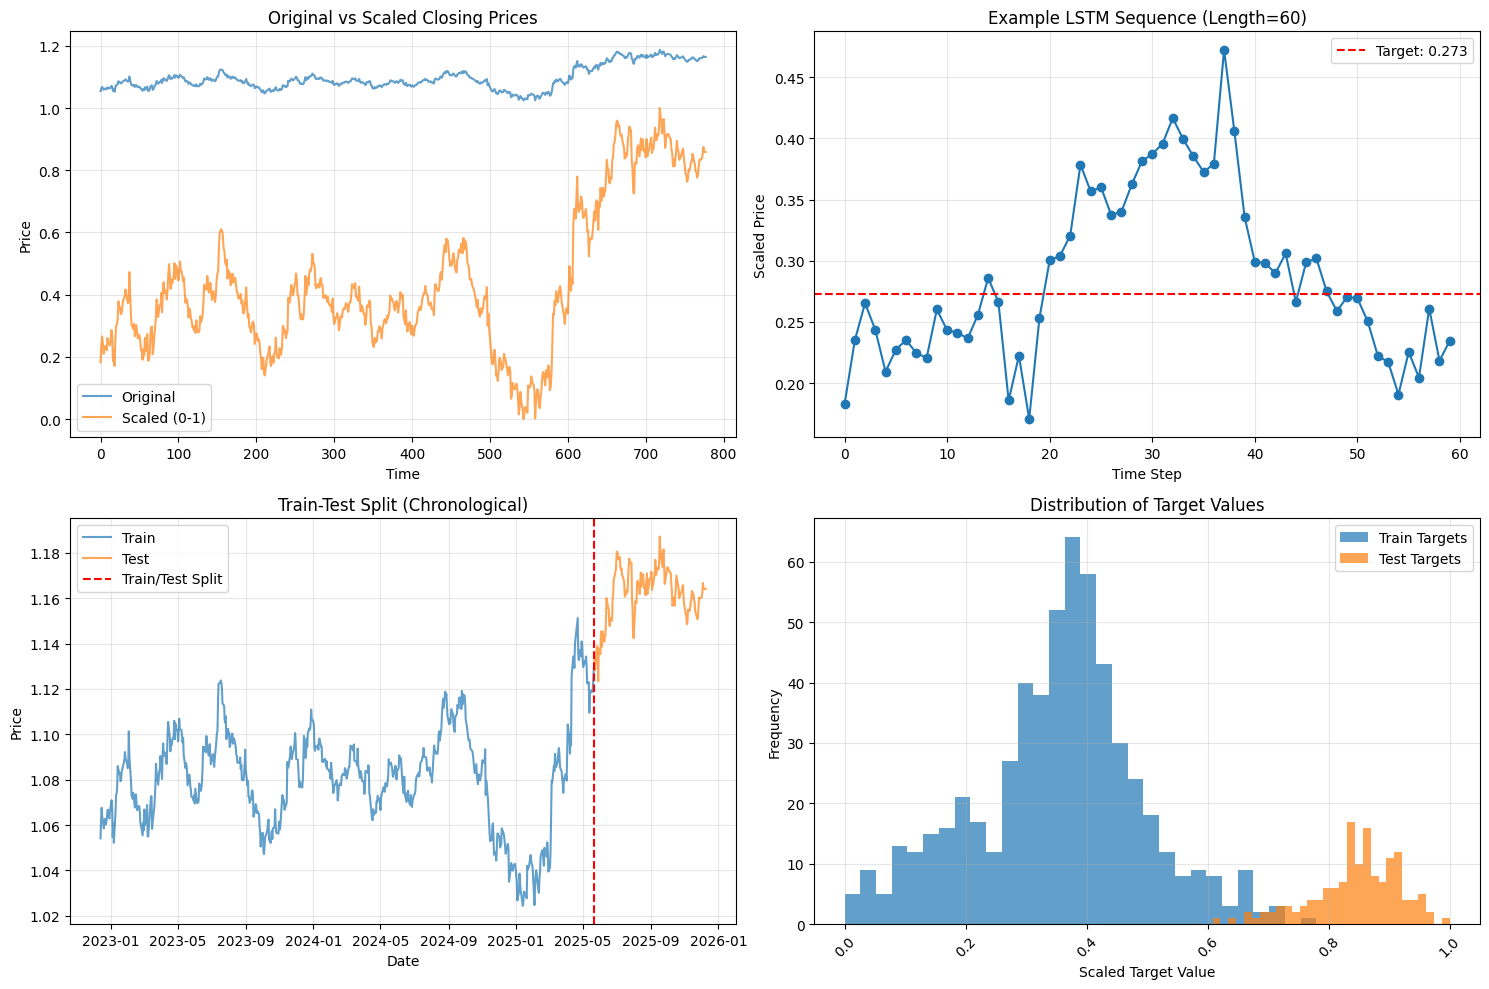

✅ LSTM preparation visualization saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/lstm_data_preparation.png


In [14]:
# CELL 8: Visualize the sequences
print("\n📊 STEP 6: Visualize LSTM sequences")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Original vs Scaled prices
axes[0, 0].plot(close_prices, label='Original', alpha=0.7)
axes[0, 0].plot(scaled_close, label='Scaled (0-1)', alpha=0.7)
axes[0, 0].set_title('Original vs Scaled Closing Prices')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Price')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Example sequence
axes[0, 1].plot(range(SEQ_LENGTH), X_train[0].flatten(), marker='o')
axes[0, 1].axhline(y=y_train[0], color='r', linestyle='--', label=f'Target: {y_train[0].item():.3f}')
axes[0, 1].set_title(f'Example LSTM Sequence (Length={SEQ_LENGTH})')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Scaled Price')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Train-test split
train_end = split_idx + SEQ_LENGTH
axes[1, 0].plot(df.index[:train_end], close_prices[:train_end], label='Train', alpha=0.7)
axes[1, 0].plot(df.index[train_end:], close_prices[train_end:], label='Test', alpha=0.7)
axes[1, 0].axvline(x=df.index[train_end], color='r', linestyle='--', label='Train/Test Split')
axes[1, 0].set_title('Train-Test Split (Chronological)')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Price')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 4: Sequence distribution
axes[1, 1].hist(y_train.flatten(), bins=30, alpha=0.7, label='Train Targets')
axes[1, 1].hist(y_test.flatten(), bins=30, alpha=0.7, label='Test Targets')
axes[1, 1].set_title('Distribution of Target Values')
axes[1, 1].set_xlabel('Scaled Target Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
lstm_viz_path = os.path.join(FIGURES, 'lstm_data_preparation.png')
plt.savefig(lstm_viz_path, dpi=100, bbox_inches='tight')
plt.show()

print(f"✅ LSTM preparation visualization saved to: {lstm_viz_path}")

In [15]:
# CELL 9: Summary
print("\n" + "="*60)
print("✅ FEATURE ENGINEERING COMPLETE")
print("="*60)

print(f"\n1. LSTM SEQUENCES:")
print(f"   • Sequence length: {SEQ_LENGTH} days")
print(f"   • Training sequences: {len(X_train)}")
print(f"   • Testing sequences: {len(X_test)}")
print(f"   • Data saved: {lstm_data_path}")

print(f"\n2. TRADITIONAL ML FEATURES:")
print(f"   • Features created: {len(feature_cols)}")
print(f"   • Samples: {len(df_ml)}")
print(f"   • Data saved: {ml_features_path}")

print(f"\n3. FILES SAVED:")
print(f"   • {lstm_data_path}")
print(f"   • {ml_features_path}")
print(f"   • {feature_list_path}")
print(f"   • {scaler_path}")
print(f"   • {lstm_viz_path}")

print(f"\n4. NEXT STEPS:")
print("   • Open 04_lstm_model.ipynb for LSTM training")
print("   • Open 05_ml_models.ipynb for traditional ML models")

print("\n🎉 Ready for model training!")


✅ FEATURE ENGINEERING COMPLETE

1. LSTM SEQUENCES:
   • Sequence length: 60 days
   • Training sequences: 574
   • Testing sequences: 144
   • Data saved: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/lstm_sequences.pkl

2. TRADITIONAL ML FEATURES:
   • Features created: 40
   • Samples: 777
   • Data saved: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/ml_features.csv

3. FILES SAVED:
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/lstm_sequences.pkl
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/ml_features.csv
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/data/processed/feature_list.json
   • /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-

In [16]:
# CELL 10: Make future predictions
print("\n🔮 Making future prediction (next day)...")

# Get the last sequence from the data
last_sequence = scaled_close[-seq_length:].reshape(1, seq_length, 1)

# Predict next day
next_day_scaled = best_model.predict(last_sequence)
next_day_price = scaler.inverse_transform(next_day_scaled)[0][0]

# Get current price
current_price = close_prices[-1][0]
predicted_change = ((next_day_price - current_price) / current_price) * 100

print(f"Current EUR/USD price: ${current_price:.4f}")
print(f"Predicted next day price: ${next_day_price:.4f}")
print(f"Predicted change: {predicted_change:+.2f}%")

# Save future prediction
future_pred = {
  'current_price': float(current_price),
  'predicted_next_day': float(next_day_price),
  'predicted_change_pct': float(predicted_change),
  'prediction_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

future_path = os.path.join(MODELS, 'future_prediction.json')
with open(future_path, 'w') as f:
  json.dump(future_pred, f, indent=2)
print(f"✅ Future prediction saved to: {future_path}")


🔮 Making future prediction (next day)...


NameError: name 'seq_length' is not defined